In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-diseases-by-medical-imaging-and-cough-sounds/Chest Diseases Using Different Medical Imaging and Cough Sounds/Chest Diseases Dataset/Chest Diseases Dataset/2. Lungs Cancer/CT Scan/Image 01 (4).jpg
/kaggle/input/chest-diseases-by-medical-imaging-and-cough-sounds/Chest Diseases Using Different Medical Imaging and Cough Sounds/Chest Diseases Dataset/Chest Diseases Dataset/2. Lungs Cancer/CT Scan/Image 01 (4).png
/kaggle/input/chest-diseases-by-medical-imaging-and-cough-sounds/Chest Diseases Using Different Medical Imaging and Cough Sounds/Chest Diseases Dataset/Chest Diseases Dataset/2. Lungs Cancer/CT Scan/Image 01 (6).jpg
/kaggle/input/chest-diseases-by-medical-imaging-and-cough-sounds/Chest Diseases Using Different Medical Imaging and Cough Sounds/Chest Diseases Dataset/Chest Diseases Dataset/2. Lungs Cancer/CT Scan/Image 01 (5).png
/kaggle/input/chest-diseases-by-medical-imaging-and-cough-sounds/Chest Diseases Using Different Medical Imaging and Cough Sounds/Chest D

In [3]:
import shutil
import os

# Define source and destination paths
src_paths = [
    "/kaggle/input/chest-diseases-by-medical-imaging-and-cough-sounds/Chest Diseases Using Different Medical Imaging and Cough Sounds/Chest Diseases Dataset/Chest Diseases Dataset/2. Lungs Cancer/CSI",
    "/kaggle/input/chest-diseases-by-medical-imaging-and-cough-sounds/Chest Diseases Using Different Medical Imaging and Cough Sounds/Chest Diseases Dataset/Chest Diseases Dataset/9. Normal/CSI"
]
dst_root = "/kaggle/working/chest_diseases_dataset"

# Create destination directory if it does not exist
os.makedirs(dst_root, exist_ok=True)

# Copy the directories
for src in src_paths:
    dst = os.path.join(dst_root, os.path.basename(os.path.dirname(src)))
    shutil.copytree(src, dst)
    print(f"Copied {src} to {dst}")

print("All directories copied successfully.")

Copied /kaggle/input/chest-diseases-by-medical-imaging-and-cough-sounds/Chest Diseases Using Different Medical Imaging and Cough Sounds/Chest Diseases Dataset/Chest Diseases Dataset/2. Lungs Cancer/CSI to /kaggle/working/chest_diseases_dataset/2. Lungs Cancer
Copied /kaggle/input/chest-diseases-by-medical-imaging-and-cough-sounds/Chest Diseases Using Different Medical Imaging and Cough Sounds/Chest Diseases Dataset/Chest Diseases Dataset/9. Normal/CSI to /kaggle/working/chest_diseases_dataset/9. Normal
All directories copied successfully.


Epoch 300/300: 100%|██████████| 14/14 [00:01<00:00,  7.06it/s, D_loss=0.13, G_loss=0.427] 


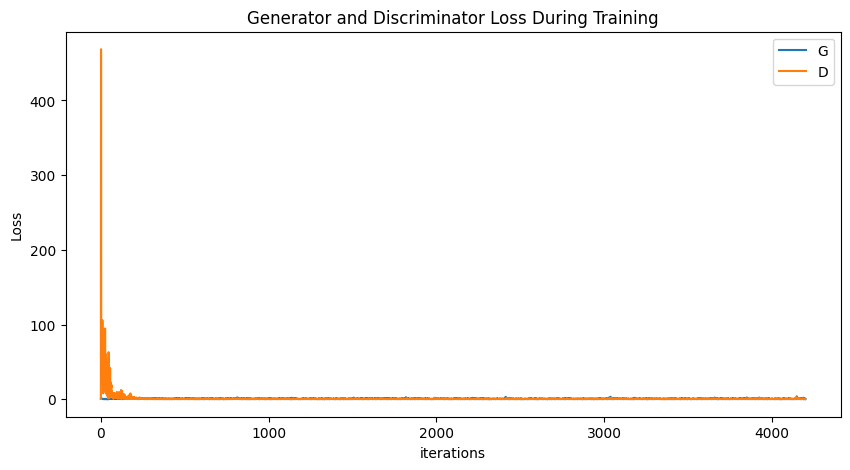

In [4]:
import os
import numpy as np
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for progress bars

# Define hyperparameters
n_epochs = 300
batch_size = 4
lr = 0.0002
b1 = 0.5
b2 = 0.999
n_cpu = 4
latent_dim = 100
n_classes = 2
img_size = (288, 432)
channels = 3
sample_interval = 100

img_shape = (channels, *img_size)

cuda = True if torch.cuda.is_available() else False

# Create the necessary directory for saving images and models
os.makedirs("images", exist_ok=True)
os.makedirs("models", exist_ok=True)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(n_classes, n_classes)

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim + n_classes, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.label_embedding = nn.Embedding(n_classes, n_classes)

        self.model = nn.Sequential(
            nn.Linear(n_classes + int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1),
        )

    def forward(self, img, labels):
        d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
        validity = self.model(d_in)
        return validity


# Loss functions
adversarial_loss = torch.nn.MSELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Configure data loader
data_dir = "/kaggle/working/chest_diseases_dataset"
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataloader = torch.utils.data.DataLoader(
    ImageFolder(root=data_dir, transform=transform),
    batch_size=batch_size,
    shuffle=True,
    num_workers=n_cpu
)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor


def sample_image(n_row, batches_done):
    """Saves a grid of generated images"""
    with torch.no_grad():
        z = torch.tensor(np.random.normal(0, 1, (n_row ** 2, latent_dim)), dtype=torch.float32, device='cuda' if cuda else 'cpu')
        labels = np.array([num % n_classes for _ in range(n_row) for num in range(n_row)])
        labels = torch.tensor(labels, dtype=torch.long, device='cuda' if cuda else 'cpu')
        gen_imgs = generator(z, labels)
        save_image(gen_imgs.data, "images/%d.png" % batches_done, nrow=n_row, normalize=True)

# Lists to store the loss values
g_losses = []
d_losses = []

# Training loop
for epoch in range(n_epochs):
    with tqdm(total=len(dataloader), desc=f"Epoch {epoch + 1}/{n_epochs}") as pbar:
        for i, (imgs, labels) in enumerate(dataloader):

            batch_size = imgs.shape[0]

            valid = torch.tensor(np.ones((batch_size, 1)), dtype=torch.float32, device='cuda' if cuda else 'cpu')
            fake = torch.tensor(np.zeros((batch_size, 1)), dtype=torch.float32, device='cuda' if cuda else 'cpu')

            real_imgs = imgs.type(FloatTensor)
            labels = labels.type(LongTensor)

            # Train Generator
            optimizer_G.zero_grad()
            z = torch.tensor(np.random.normal(0, 1, (batch_size, latent_dim)), dtype=torch.float32, device='cuda' if cuda else 'cpu')
            gen_labels = torch.tensor(np.random.randint(0, n_classes, batch_size), dtype=torch.long, device='cuda' if cuda else 'cpu')

            # Ensure gen_labels are within valid range
            assert gen_labels.max().item() < n_classes, f"Generated label out of range: {gen_labels.max().item()}"
            assert gen_labels.min().item() >= 0, f"Generated label out of range: {gen_labels.min().item()}"

            gen_imgs = generator(z, gen_labels)
            validity = discriminator(gen_imgs, gen_labels)
            g_loss = adversarial_loss(validity, valid)

            g_loss.backward()
            optimizer_G.step()

            # Train Discriminator
            optimizer_D.zero_grad()
            validity_real = discriminator(real_imgs, labels)
            d_real_loss = adversarial_loss(validity_real, valid)

            validity_fake = discriminator(gen_imgs.detach(), gen_labels)
            d_fake_loss = adversarial_loss(validity_fake, fake)

            d_loss = (d_real_loss + d_fake_loss) / 2

            d_loss.backward()
            optimizer_D.step()

            # Save losses for plotting
            g_losses.append(g_loss.item())
            d_losses.append(d_loss.item())

            pbar.set_postfix(D_loss=d_loss.item(), G_loss=g_loss.item())
            pbar.update(1)

            batches_done = epoch * len(dataloader) + i
            if batches_done % sample_interval == 0:
                sample_image(n_row=10, batches_done=batches_done)

    # Save the model every 200 epochs
    if (epoch + 1) % 50 == 0:
        torch.save(generator.state_dict(), f"models/generator_epoch_{epoch+1}.pth")
#         torch.save(discriminator.state_dict(), f"models/discriminator_epoch_{epoch+1}.pth")

# Plot the loss values
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_losses, label="G")
plt.plot(d_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig("loss_plot.png")
plt.show()

# Save the final models
torch.save(generator.state_dict(), "models/generator_final.pth")
# torch.save(discriminator.state_dict(), "models/discriminator_final.pth")

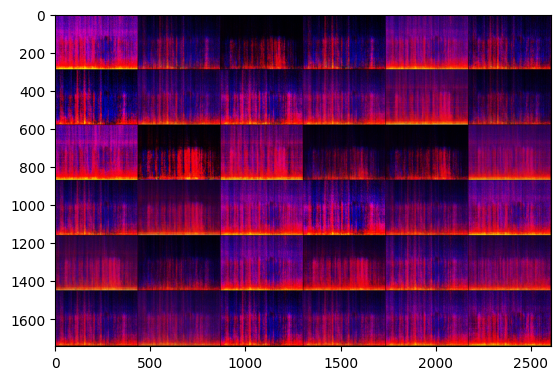

In [20]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import save_image, make_grid
import torch.nn as nn

# Define the same hyperparameters and model architectures used during training
latent_dim = 100
n_classes = 2
img_size = (288, 432)
channels = 3
img_shape = (channels, *img_size)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(n_classes, n_classes)

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim + n_classes, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), *img_shape)
        return img

# Initialize generator
generator = Generator()

# Load the saved model weights
generator.load_state_dict(torch.load("/kaggle/working/models/generator_epoch_250.pth"))

# Ensure the model is in evaluation mode
generator.eval()

# Generate new images with label 0
def generate_images_label_0(num_images, save_path=None):
    noise = torch.tensor(np.random.normal(0, 1, (num_images, latent_dim)), dtype=torch.float32)
    labels = torch.zeros(num_images, dtype=torch.long)  # All labels are 0
    
    with torch.no_grad():
        generated_images = generator(noise, labels)

    if save_path:
        save_image(generated_images.data, save_path, nrow=int(np.sqrt(num_images)), normalize=True)

    return generated_images

# Example usage
num_images = 36
generated_images = generate_images_label_0(num_images, save_path="generated_images_label_0.png")

# Display the generated images
grid_img = make_grid(generated_images, nrow=int(np.sqrt(num_images)), normalize=True)
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

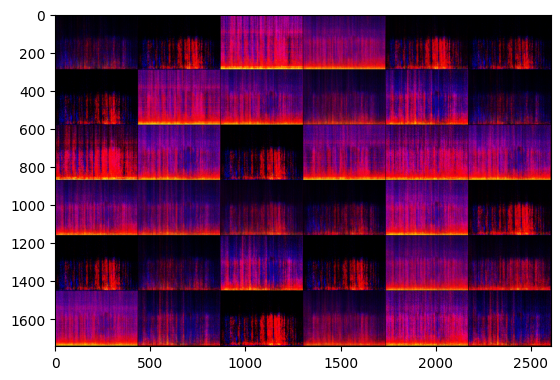

In [21]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import save_image, make_grid
import torch.nn as nn

# Define the same hyperparameters and model architectures used during training
latent_dim = 100
n_classes = 2
img_size = (288, 432)
channels = 3
img_shape = (channels, *img_size)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(n_classes, n_classes)

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim + n_classes, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), *img_shape)
        return img

# Initialize generator
generator = Generator()

# Load the saved model weights
generator.load_state_dict(torch.load("/kaggle/working/models/generator_epoch_250.pth"))

# Ensure the model is in evaluation mode
generator.eval()

# Generate new images with label 1
def generate_images_label_1(num_images, save_path=None):
    noise = torch.tensor(np.random.normal(0, 1, (num_images, latent_dim)), dtype=torch.float32)
    labels = torch.ones(num_images, dtype=torch.long)  # All labels are 1
    
    with torch.no_grad():
        generated_images = generator(noise, labels)

    if save_path:
        save_image(generated_images.data, save_path, nrow=int(np.sqrt(num_images)), normalize=True)

    return generated_images

# Example usage
num_images = 36
generated_images = generate_images_label_1(num_images, save_path="generated_images_label_1.png")

# Display the generated images
grid_img = make_grid(generated_images, nrow=int(np.sqrt(num_images)), normalize=True)
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()